In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from PIL import Image, ImageEnhance, ImageChops
import random
from shutil import copyfile
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle as pkl
import warnings
warnings.filterwarnings("ignore")

2024-04-15 05:12:08.632570: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-15 05:12:08.632673: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-15 05:12:08.758248: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def get_format_counts(path):
    ''' gets the counts of each image format in the specified path'''
    counts = {}

    for image in os.listdir(path):
        img_type = image.split('.')[-1]
        if img_type in counts:
            counts[img_type] += 1
        else:
            counts.update({img_type: 1})
    
    return counts

# Get the counts of formats in the authentic images folder
print(get_format_counts('/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Au'))

# Get the counts of formats in the tempered images folder
print(get_format_counts('/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Tp'))

{'jpg': 7437, 'bmp': 54, 'db': 1}
{'jpg': 2064, 'tif': 3059, 'txt': 1, 'db': 1}


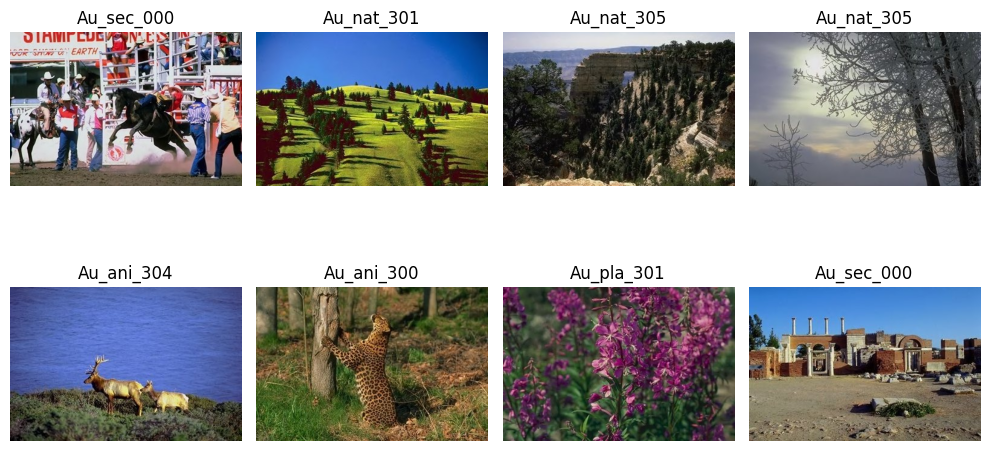

In [3]:
def show_images(path):
    # Get random 8 images from the path
    image_files = random.sample(os.listdir(path), 8)

    # Create a 2x4 grid of subplots
    fig, axes = plt.subplots(2, 4, figsize=(10, 6))

    # Iterate over the image files and plot them in the subplots
    for i, ax in enumerate(axes.flatten()):
        # Load and plot the image
        image_path = os.path.join(path, image_files[i])
        image = plt.imread(image_path)
        ax.imshow(image)
        ax.set_title(image_files[i][:10])  # Set the title as the image filename
        ax.axis('off')  # Turn off axis labels

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()
    

# Path to the authentic images directory
image_dir = '/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Au'
show_images(image_dir)

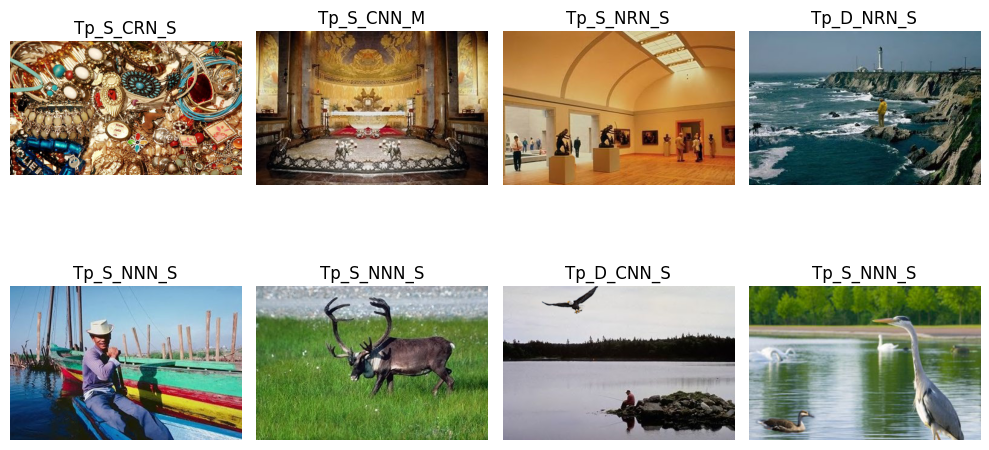

In [4]:
# Path to the tampered images directory
image_dir = '/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Tp'
show_images(image_dir)

In [5]:
def image_to_ela(path, quality, resave_path):
    ''' Gets images specified as path and resaves it at a new path resave_path at specified quality'''
    try:
        # Check if the file format is supported (JPEG or PNG)
        if path.endswith('jpg') or path.endswith('jpeg') or path.endswith('png'):
            # Open the image and convert it to RGB mode
            image = Image.open(path).convert('RGB')
            
            # Resave the image with the specified quality
            image.save('resaved.jpg', 'JPEG', quality=quality)
            resaved = Image.open('resaved.jpg')

            # Calculate the ELA (Error Level Analysis) image by taking the difference between the original and resaved image
            ela_image = ImageChops.difference(image, resaved)

            # Get the minimum and maximum pixel values in the ELA image
            band_values = ela_image.getextrema()
            max_value = max([val[1] for val in band_values])

            # If the maximum value is 0, set it to 1 to avoid division by zero
            if max_value == 0:
                max_value = 1

            # Scale the pixel values of the ELA image to the range [0, 255]
            scale = 255.0 / max_value
            ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

            # Save the ELA image with the same filename in the specified resave path
            ela_image.save(os.path.join(resave_path, os.path.basename(path)), 'JPEG')
    except Exception as e:
        print(f'Could not convert {path} to ELA: {str(e)}')

In [6]:
def preprocess_data(parent_path, files, resave_path):
    ''' Loops through a directory and applies the image_to_ela function to each image in the directory'''
    for file in files:
        image_to_ela(os.path.join(parent_path, file), 90, resave_path)

In [7]:
# get list of all authentic images
auth_files = os.listdir('/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Au')

# get list of all Tempered images
doc_files = os.listdir('/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Tp')

# create the all_reals and all_docs where we save the real and doctored ELA images
os.mkdir('/kaggle/working/all_reals')
os.mkdir('/kaggle/working/all_Doc')

# converting  validation real images to ela
parent_path = '/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Au'
preprocess_data(parent_path, auth_files, '/kaggle/working/all_reals')

# converting training doctored images to ela
parent_path = '/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Tp'
preprocess_data(parent_path, doc_files, '/kaggle/working/all_Doc')

print('There are ' + str(len(os.listdir('/kaggle/working/all_reals'))) + ' supported Authentic Images')
print('There are ' + str(len(os.listdir('/kaggle/working/all_Doc'))) + ' supported Tempered Images')

There are 7437 supported Authentic Images
There are 2064 supported Tempered Images


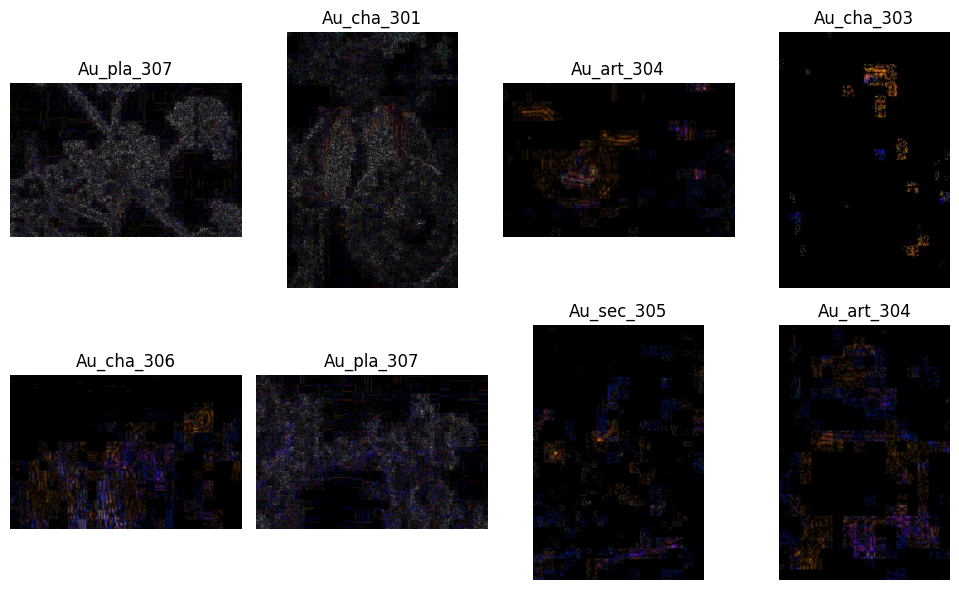

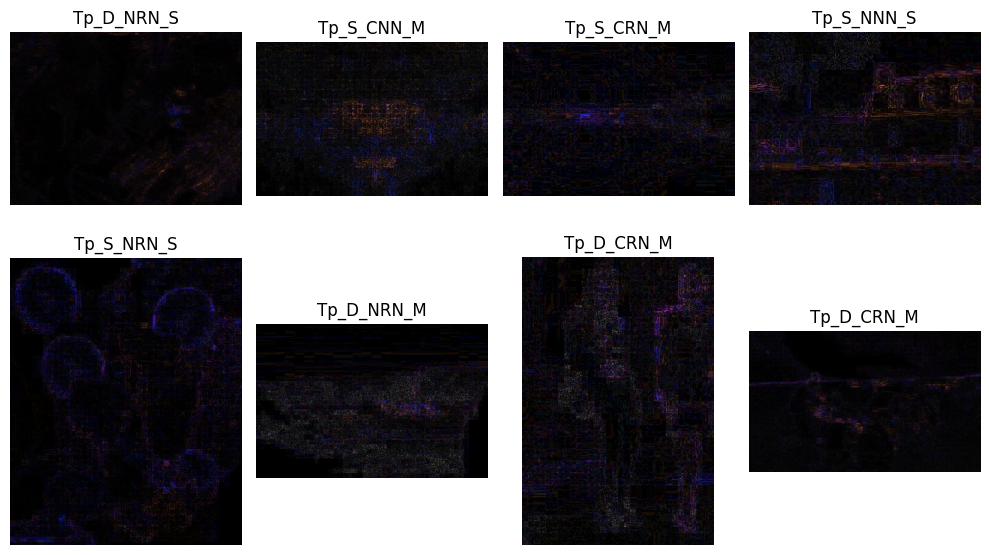

In [8]:
# Path to the authentic ela images directory
image_dir = '/kaggle/working/all_reals'
show_images(image_dir)

# Path to the tempered ela images directory
image_dir = '/kaggle/working/all_Doc'
show_images(image_dir)

In [9]:
# creating the parent directory for both the Training and Validation datasets
ela_path = os.path.join(os.getcwd(), 'ela_images')

# create path for training set and the different labels
auth_path_train = os.path.join(ela_path, 'train',  'Real')
temp_path_train = os.path.join(ela_path, 'train', 'Doctored')
os.makedirs(auth_path_train)
os.makedirs(temp_path_train)

# create path for validation set and its different labels
auth_path_val = os.path.join(ela_path, 'Val',  'Real')
temp_path_val = os.path.join(ela_path, 'Val', 'Doctored')
os.makedirs(auth_path_val)
os.makedirs(temp_path_val)

In [10]:
# Get the list of files in the 'all_reals' directory
real_files = os.listdir('/kaggle/working/all_reals')

# Get the list of files in the 'all_Doc' directory
doc_files = os.listdir('/kaggle/working/all_Doc')

# Calculate the total length for training and validation sets for doctored images
total_len_train_doc = int((80 / 100) * len(doc_files))
total_len_val_doc = int((20 / 100) * len(doc_files))

# Randomly select files for validation from the authentic image files
val_auth = random.choices(real_files, k=total_len_val_doc)

# Select the remaining files for training from the authentic image files
train_auth = [f for f in real_files if f not in val_auth][:total_len_train_doc]

# Randomly select files for validation from the doctored image files
val_doc = random.choices(doc_files, k=total_len_val_doc)

# Select the remaining files for training from the doctored image files
train_doc = [f for f in doc_files if f not in val_doc][:total_len_train_doc]

# Path to the destination directories for training and validation authentic images
auth_path_train = '/kaggle/working/ela_images/train/Real'
auth_path_val = '/kaggle/working/ela_images/Val/Real'

# Path to the destination directories for training and validation doctored images
temp_path_train = '/kaggle/working/ela_images/train/Doctored'
temp_path_val = '/kaggle/working/ela_images/Val/Doctored'

# Copy the training authentic images to ela_images/train/Real
for item in train_auth:
    copyfile('/kaggle/working/all_reals/{}'.format(item), "{}/{}".format(auth_path_train, os.path.basename(item)))

# Copy the validation authentic images to ela_images/Val/Real
for item in val_auth:
    copyfile('/kaggle/working/all_reals/{}'.format(item), "{}/{}".format(auth_path_val, os.path.basename(item)))

# Copy the training doctored images to ela_images/train/Doctored
for item in train_doc:
    copyfile('/kaggle/working/all_Doc/{}'.format(item), "{}/{}".format(temp_path_train, os.path.basename(item)))

# Copy the validation doctored images to ela_images/Val/Doctored
for item in val_doc:
    copyfile('/kaggle/working/all_Doc/{}'.format(item), "{}/{}".format(temp_path_val, os.path.basename(item)))

# Print the lengths of the validation and training sets for authentic and doctored images
print("There are a total of " + str(len(train_auth)) + "Authentic Images in the training set")
print("There are a total of " + str(len(train_doc)) + "Doctored Images in the training set")
print("There are a total of " + str(len(val_auth)) + "Authentic Images in the Validation set")
print("There are a total of " + str(len(val_doc)) + "Doctored Images in the Validation set")

There are a total of 1651Authentic Images in the training set
There are a total of 1651Doctored Images in the training set
There are a total of 412Authentic Images in the Validation set
There are a total of 412Doctored Images in the Validation set


In [11]:
# Create an instance of the ImageDataGenerator
datagen = ImageDataGenerator()

# Generate training images
train_images = datagen.flow_from_directory(
    '/kaggle/working/ela_images/train',
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary'
)

# Generate validation images
validation_images = datagen.flow_from_directory(
    '/kaggle/working/ela_images/Val',
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary'
)
train_images1 = datagen.flow_from_directory(
    '/kaggle/working/ela_images/train',
    target_size=(150,150),
    batch_size=32,
    class_mode='binary'
)

# Generate validation images
validation_images1 = datagen.flow_from_directory(
    '/kaggle/working/ela_images/Val',
    target_size=(150,150),
    batch_size=32,
    class_mode='binary'
)

train_images2= datagen.flow_from_directory(
    '/kaggle/working/ela_images/train',
    target_size=(224,224),
    batch_size=32,
    class_mode='binary'
)

# Generate validation images
validation_images2= datagen.flow_from_directory(
    '/kaggle/working/ela_images/Val',
    target_size=(224,224),
    batch_size=32,
    class_mode='binary'
)

Found 3302 images belonging to 2 classes.
Found 774 images belonging to 2 classes.
Found 3302 images belonging to 2 classes.
Found 774 images belonging to 2 classes.
Found 3302 images belonging to 2 classes.
Found 774 images belonging to 2 classes.


In [12]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3, VGG16, MobileNetV2
from tensorflow.keras import layers, models

# Step 1: Load pre-trained GoogleNet, VGG and MobileNetV2 models (without top classification layers)
google_net = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
mobile_net = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Step 2: Freeze the layers of the base models (optional, depends on the dataset size)
for layer in google_net.layers:
    layer.trainable = False
for layer in vgg.layers:
    layer.trainable = False
for layer in mobile_net.layers:
    layer.trainable = False
    
# Step 3: Create fusion model
input_layer = tf.keras.Input(shape=(224, 224, 3))
google_net_features = google_net(input_layer)
vgg_features = vgg(input_layer)
mobile_net_features = mobile_net(input_layer)

# Step 4: Reshape the GoogleNet features to match the shape of VGG features
google_net_features = layers.GlobalAveragePooling2D()(google_net_features)
google_net_features = layers.Dense(1024, activation='relu')(google_net_features)
google_net_features = layers.Reshape((1, 1, 1024))(google_net_features)  # Reshape instead of expand_dims
google_net_features = layers.UpSampling2D(size=(7, 7))(google_net_features)

# Reshape MobileNetV4 Features (if necessary)
if len(mobile_net_features.shape) == 2:
    mobile_net_features = layers.Reshape((1, 1, mobile_net_features.shape[-1]))(mobile_net_v4_features)

# Step 5: Concatenate the feature representations from both models
fusion_features = layers.Concatenate()([google_net_features, vgg_features, mobile_net_features])

# Step 6: Add additional layers for fusion and making predictions
fusion_features = layers.GlobalAveragePooling2D()(fusion_features)
fusion_features = layers.Dense(1024, activation='relu')(fusion_features)
predictions = layers.Dense(1, activation='sigmoid')(fusion_features)

# Step 7: Create the fusion model
model = models.Model(inputs=input_layer, outputs=predictions)

# Step 8: Compile the model with an appropriate optimizer and loss function
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Now the 'model' is a fusion of GoogleNet and VGG models for your specific task

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
history = model.fit(
    train_images2,  
    steps_per_epoch=int(len(train_images) / 8),
    epochs=110,
    validation_data=validation_images2
)

Epoch 1/110


I0000 00:00:1713158162.043320     130 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1713158162.123228     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.5517 - loss: 3.0442

W0000 00:00:1713158174.603681     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


13/13 ━━━━━━━━━━━━━━━━━━━━ 102s 3s/step - accuracy: 0.5579 - loss: 2.9665 - val_accuracy: 0.8023 - val_loss: 0.4563
Epoch 2/110
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 616ms/step - accuracy: 0.8226 - loss: 0.3814 - val_accuracy: 0.8850 - val_loss: 0.3121
Epoch 3/110
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 618ms/step - accuracy: 0.9083 - loss: 0.2628 - val_accuracy: 0.9160 - val_loss: 0.2345
Epoch 4/110
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 613ms/step - accuracy: 0.8936 - loss: 0.2836 - val_accuracy: 0.9186 - val_loss: 0.2274
Epoch 5/110
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 613ms/step - accuracy: 0.8922 - loss: 0.2992 - val_accuracy: 0.9160 - val_loss: 0.2149
Epoch 6/110
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8981 - loss: 0.2555 - val_accuracy: 0.9147 - val_loss: 0.2124
Epoch 7/110
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 605ms/step - accuracy: 0.8914 - loss: 0.2606 - val_accuracy: 0.8953 - val_loss: 0.2727
Epoch 8/110
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 609ms/step - accuracy: 0.8689 - loss: 0.3061 - val_accuracy: 0.8760 - 

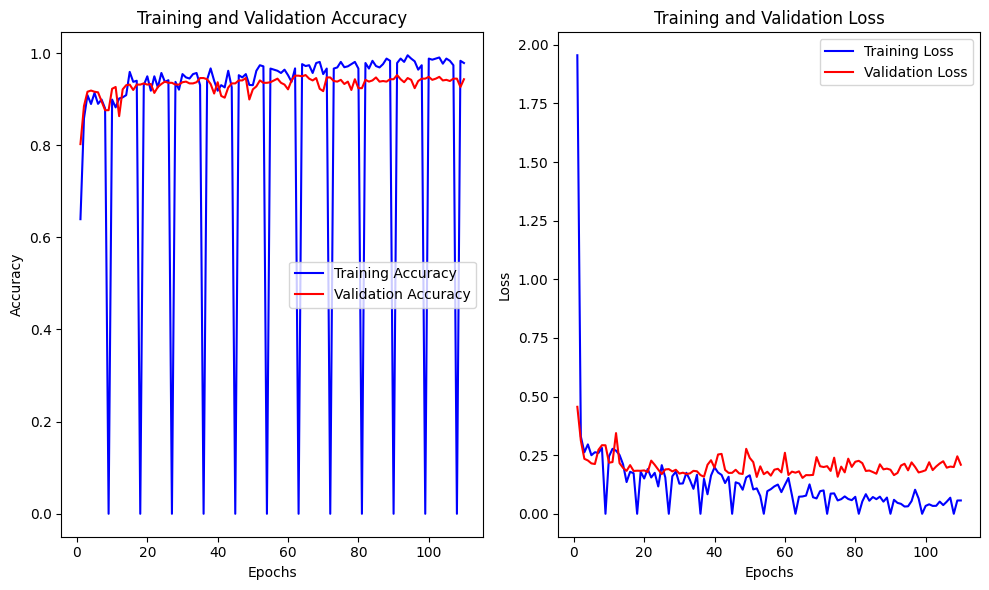

In [14]:
def plot_accuracy(history):
    # Create a 2x2 grid of subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 6))
        
    # Get the training and validation accuracy values from the history object
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    # Get the training and validation loss values from the history object
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Get the number of epochs
    epochs = range(1, len(train_acc) + 1)
    
    # Plot the training and validation accuracy
    axes[0].plot(epochs, train_acc, 'b', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'r', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    
    # Plot the training and validation loss
    axes[1].plot(epochs, train_loss, 'b', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'r', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    
    # Adjust the layout
    fig.tight_layout()
    
    # Show the plot
    plt.show()


plot_accuracy(history)